In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Joining

Data scientists very frequently want to *join* two or more relations together
in order to connect records between relations. For instance, an online
bookstore might have one relation with the books each user has ordered and a
second relation with the genres of each book. By joining the two relations
together, the data scientist can see what genres each user prefers.

We'll continue looking at the baby names data. We'll use joins to check some
trends mentioned in the New York Times article about baby names
{cite}`williamsLilith2021`. The article talks about how certain categories of
names have become more or less popular over time. For instance, it mentions
that mythological names like Julius and Cassius have become popular, while baby
boomer names like Susan and Debbie have become less popular. How has the
popularity of these categories changed over time?

We've taken the names and categories in the NYT article and put them in a small
relation named `nyt`:

In [5]:
# Set up connection to database
import sqlalchemy
db = sqlalchemy.create_engine('sqlite:///babynames.db')

In [6]:
query = ''' 
SELECT *
FROM nyt;
'''

pd.read_sql(query, db)

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
...,...,...
20,Venus,celestial
21,Celestia,celestial
22,Skye,celestial


:::{note}

Notice that the code above runs a query on `babynames.db`, the same database
that contains the larger `baby` relation from the previous sections. SQL
databases can hold more than one relation, making them very useful when we need
to work with many data tables at once. CSV files, on the other hand, typically
contain one data table each---if we perform a data analysis that uses twenty
data tables, we might need to keep track of the names, locations, and versions
of twenty CSV files. Instead, it could be simpler to store all the data tables
in a SQLite database stored in a single file.

:::

To see how popular the categories of names are, we join the `nyt` relation with
the `baby` relation to get the name counts from `baby`. We'll start by
displaying the first few rows of the `baby` relation:

In [7]:
query = ''' 
SELECT *
FROM baby
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
7,Lucas,M,11281,2020
8,Henry,M,10705,2020
9,Alexander,M,10151,2020


Imagine going down each row in `baby` and asking, is this name in the `nyt`
table? If so, then add the value in the `category` column to the row. That's
the basic idea behind a join. Let's look at a few simpler examples first.

## Inner Joins

We've made smaller versions of the `baby` and `nyt` tables so it's easier to
see what happens when we join tables together. The relations are called
`baby_small` and `nyt_small`.

In [13]:
query = ''' 
SELECT *
FROM baby_small;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Noah,M,18252,2020
1,Julius,M,960,2020
2,Karen,M,6,2020
3,Karen,F,325,2020
4,Noah,F,305,2020


In [15]:
query = ''' 
SELECT *
FROM nyt_small;
'''

pd.read_sql(query, db)

,nyt_name,category
0,Karen,boomer
1,Julius,mythology
2,Freya,mythology


To join tables in SQL, we use the `JOIN` clause to say which tables we want to
join, and the `ON` clause to specify a predicate for joining the tables. Here's
an example:

In [16]:
query = ''' 
SELECT *
FROM baby_small JOIN nyt_small
  ON baby_small.Name = nyt_small.nyt_name
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year,nyt_name,category
0,Julius,M,960,2020,Julius,mythology
1,Karen,M,6,2020,Karen,boomer
2,Karen,F,325,2020,Karen,boomer


Notice that the new table has the columns of both `baby_small` and `nyt_small`
tables. The rows with the name Noah are gone. And the remaining rows have their
matching `category` from `nyt_small`.

The query above can be read as follows:

```sql
SELECT *
FROM baby_small JOIN nyt_small   -- the tables to join
  ON baby_small.Name = nyt_small.nyt_name
  -- only join rows together when the names are equal
```

When we join two tables together, we tell SQL the column(s) from each
table that we want to use to join using a predicate with the `ON` keyword.
SQL matches rows together when the values in the joining columns match, as
shown in {numref}`fig:sql-inner-join`.

```{figure} figures/sql-inner-join.svg
---
name: fig:sql-inner-join
alt: sql-inner-join
---
To join, SQL matches rows using the values in the `Name` and `nyt_name`
columns. For inner joins (the default), rows that don't have matching values
are dropped.
```

By default, SQL does an *inner join*. If either table has rows that don't
have matches in the other table, SQL drops those rows from the result. In
this case, the Noah rows in `baby_small` don't have matches in
`nyt_small`, so they are dropped. Also, the Freya row in `nyt_small`
doesn't have matches in `baby_small`, so it's dropped as well. Only the
rows with a match in both tables stay in the final result.

## Left, Right, and Outer Joins

We sometimes want to keep rows without a match instead of dropping them
entirely. There are other types of joins---left, right, and outer---that keep
rows even when they don't have a match.

In a *left join*, rows in the left table without a match are kept in the final
result, as shown in {numref}`fig:sql-left-join`.

```{figure} figures/sql-left-join.svg
---
name: fig:sql-left-join
alt: sql-left-join
---
In a left join, rows in the left table that don't have matching values are kept. 
```

To do a left join in `pandas`, use `LEFT JOIN` instead of `JOIN`:

In [17]:
query = ''' 
SELECT *
FROM baby_small LEFT JOIN nyt_small
  ON baby_small.Name = nyt_small.nyt_name
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year,nyt_name,category
0,Noah,M,18252,2020,None,None
1,Julius,M,960,2020,Julius,mythology
2,Karen,M,6,2020,Karen,boomer
3,Karen,F,325,2020,Karen,boomer
4,Noah,F,305,2020,None,None


Notice that the Noah rows are kept in the final table. Since those rows didn't
have a match in the `nyt_small` dataframe, SQL leaves `NULL` values in the
`nyt_name` and `category` columns (which are then converted to `None` values
when read into a `pandas` dataframe). Also, notice that the Freya row in
`nyt_small` is still dropped.

A *right join* works similarly to the left join, except that non-matching rows
in the right table are kept instead of the left table. SQLite doesn't support
right joins directly, but we can perform the same join by reversing the order
of relations when we use `LEFT JOIN`:

In [18]:
query = ''' 
SELECT *
FROM nyt_small LEFT JOIN baby_small
  ON baby_small.Name = nyt_small.nyt_name
'''

pd.read_sql(query, db)

,nyt_name,category,Name,Sex,Count,Year
0,Karen,boomer,Karen,F,325.0,2020.0
1,Karen,boomer,Karen,M,6.0,2020.0
2,Julius,mythology,Julius,M,960.0,2020.0
3,Freya,mythology,None,None,NaN,NaN


Finally, an *outer join* keeps rows from both tables even when they don't have
a match. SQLite doesn't have a built-in keyword for outer joins. In cases where
an outer join is needed, we have to either use a different SQL engine or
perform an outer join via `pandas`. However, in our (the author's) experience,
outer joins are rarely used in practice compared to inner and left joins.

## Example: Popularity of NYT Name Categories

Now, let's return to the full `baby` and `nyt` relations.

In [19]:
query = ''' 
SELECT *
FROM baby
LIMIT 10
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
7,Lucas,M,11281,2020
8,Henry,M,10705,2020
9,Alexander,M,10151,2020


In [20]:
query = ''' 
SELECT *
FROM nyt
'''

pd.read_sql(query, db)

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
...,...,...
20,Venus,celestial
21,Celestia,celestial
22,Skye,celestial


We want to know how the popularity of name categories in `nyt` have changed
over time. To answer this question:

1. Inner join `baby` with `nyt`, matching rows where the names are equal.
2. Group the table by `category` and `Year`
3. Aggregate the counts using a sum.

In [30]:
query = ''' 
SELECT
  category,
  Year,
  SUM(Count) AS count           -- [3]
FROM baby JOIN nyt              -- [1]
  ON baby.Name = nyt.nyt_name   -- [1]
GROUP BY category, Year         -- [2]
'''

cate_counts = pd.read_sql(query, db)
cate_counts

,category,Year,count
0,boomer,1880,292
1,boomer,1881,298
2,boomer,1882,326
...,...,...,...
647,mythology,2018,2944
648,mythology,2019,3320
649,mythology,2020,3489


The bracketed numbers (`[1]`, `[2]`, `[3]`) in the query above show how each
step in our plan maps to the parts of the SQL query. Notice that the numbers
appear out of order. We often think of the `SELECT` statement as the *last*
piece of the query to execute although it appears first.

Now, we can plot the popularity of individual categories:

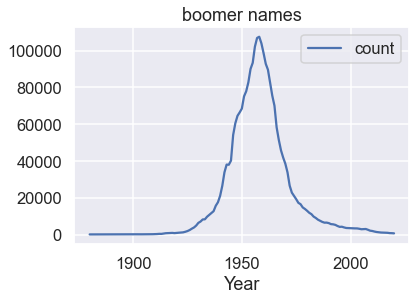

In [31]:
(cate_counts
 .query('category == "boomer"')
 .plot('Year', 'count')
)
plt.title('boomer names');

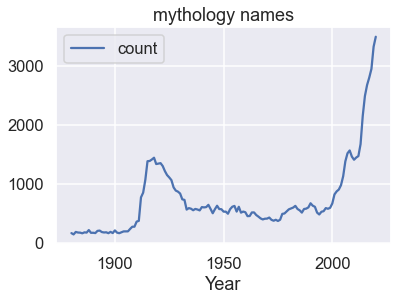

In [32]:
(cate_counts
 .query('category == "mythology"')
 .plot('Year', 'count')
)
plt.title('mythology names');

As the NYT article claims, "baby boomer" names have become less popular after
2000, while mythological names have become more popular.

We can use the `seaborn` package to plot the popularities of all the categories
at once. We won't explain this code since we cover `seaborn` in more depth in
the {ref}`ch:viz` chapter. Instead, look over the plots below and see whether
they support the claims made in the New York Times article.

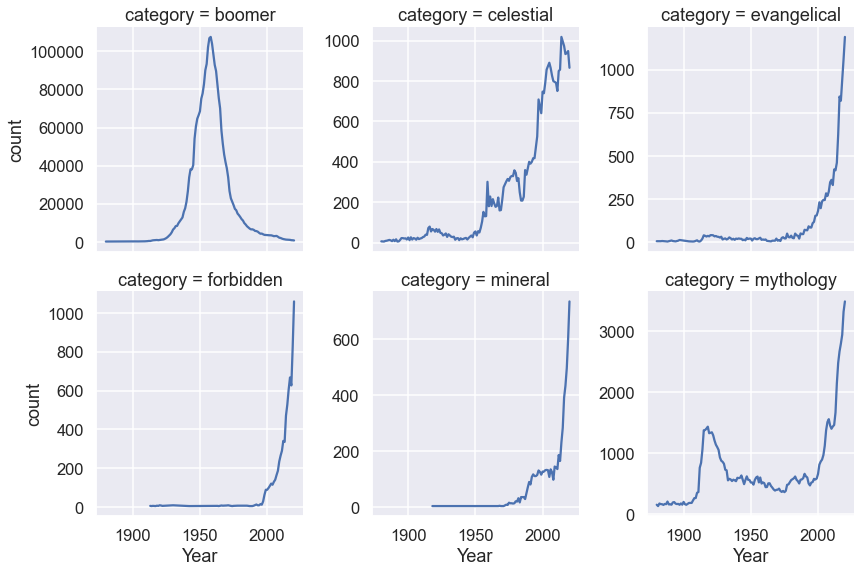

In [33]:
sns.relplot(data=cate_counts, x='Year', y='count',
            col='category', kind='line', col_wrap=3,
            facet_kws={'sharey': False},
            height=4);